The idea to create this model was sparked by a tweet: https://twitter.com/fchollet/status/711594805692792832

I studied the following resources to be able to finish the model:
0. http://artint.info/html/ArtInt_265.html
1. https://edersantana.github.io/articles/keras_rl/
2. http://www.nervanasys.com/demystifying-deep-reinforcement-learning/
3. http://keras.io/

Here's a gif of the model playing a few games of catching fruit:
<img src="files/fruit.gif" />

Btw, I really, *really* liked Eder Santana's idea to apply big idea's to toy examples. I hope to do this more often to feed my fingerspitzengefühl.

In [1]:
from random import sample as rsample

import numpy as np

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten
from keras.optimizers import SGD, RMSprop

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
GRID_SIZE = 10

def episode():
    """ 
    Coroutine of episode. 
    
    Action has to be explicitly send to this coroutine.
    """
    x, y, z = (
        np.random.randint(0, GRID_SIZE),  # X of fruit
        0,  # Y of dot
        np.random.randint(1, GRID_SIZE - 1)  # X of basket
    )
    while True:
        X = np.zeros((GRID_SIZE, GRID_SIZE))  # Reset grid
        X[y, x] = 1.  # Draw fruit
        bar = range(z - 1, z + 2)
        X[-1, bar] = 1.  # Draw basket
        
        # End of game is known when fruit is at penultimate line of grid.
        # End represents either a win or a loss
        end = int(y >= GRID_SIZE - 2)
        if end and x not in bar:
            end *= -1
            
        action = yield X[np.newaxis], end    
        if end:
            break

        z = min(max(z + action, 1), GRID_SIZE - 2)
        y += 1

            
def experience_replay(batch_size):
    """
    Coroutine of experience replay.
    
    Provide a new experience by calling send, which in turn yields 
    a random batch of previous replay experiences.
    """
    memory = []
    while True:
        experience = yield rsample(memory, batch_size) if batch_size <= len(memory) else None
        memory.append(experience)


In [3]:
nb_epochs = 1000
batch_size = 128
epsilon = .8
gamma = .8

# Recipe of deep reinforcement learning model
model = Sequential()
model.add(Convolution2D(16, nb_row=3, nb_col=3, input_shape=(1, GRID_SIZE, GRID_SIZE), activation='relu'))
model.add(Convolution2D(16, nb_row=3, nb_col=3, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(3))
model.compile(RMSprop(), 'MSE')

exp_replay = experience_replay(batch_size)
exp_replay.next()  # Start experience-replay coroutine

for i in xrange(nb_epochs):
    ep = episode()
    S, won = ep.next()  # Start coroutine of single entire episode
    loss = 0.
    try:
        while True:
            action = np.random.randint(-1, 2) 
            if np.random.random() > epsilon:
                # Get the index of the maximum q-value of the model.
                # Subtract one because actions are either -1, 0, or 1
                action = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1

            S_prime, won = ep.send(action)
            experience = (S, action, won, S_prime)
            S = S_prime
            
            batch = exp_replay.send(experience)
            if batch:
                inputs = []
                targets = []
                for s, a, r, s_prime in batch:
                    # The targets of unchosen actions are the q-values of the model,
                    # so that the corresponding errors are 0. The targets of chosen actions
                    # are either the rewards, in case a terminal state has been reached, 
                    # or future discounted q-values, in case episodes are still running.
                    t = model.predict(s[np.newaxis]).flatten()
                    t[a + 1] = r
                    if not r:
                        t[a + 1] = r + gamma * model.predict(s_prime[np.newaxis]).max(axis=-1)
                    targets.append(t)
                    inputs.append(s)
                
                loss += model.train_on_batch(np.array(inputs), np.array(targets))

    except StopIteration:
        pass
    
    if (i + 1) % 100 == 0:
        print 'Epoch %i, loss: %.6f' % (i + 1, loss)


Epoch 100, loss: 0.026815
Epoch 200, loss: 0.023206
Epoch 300, loss: 0.022220
Epoch 400, loss: 0.013861
Epoch 500, loss: 0.010943
Epoch 600, loss: 0.008557
Epoch 700, loss: 0.010435
Epoch 800, loss: 0.003742
Epoch 900, loss: 0.003236
Epoch 1000, loss: 0.005833


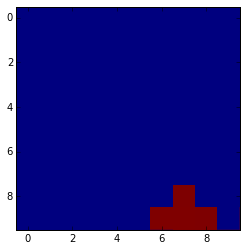

In [5]:
def save_img():
    frame = 0
    while True:
        screen = (yield)
        plt.imshow(screen[0], interpolation='none')
        plt.savefig('images/%03i.png' % frame)
        frame += 1
    
img_saver = save_img()
img_saver.next()

for _ in xrange(10):
    g = episode()
    S, _ = g.next()
    img_saver.send(S)
    try:
        while True:
            act = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1
            S, _ = g.send(act)
            img_saver.send(S)

    except StopIteration:
        g.close()

img_saver.close()
